In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats
from tqdm import tqdm  # Progress bar

import time

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler  # Standardizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # One hot Encoder
from scipy.sparse import csr_matrix  # For sparse matrix

from sklearn.model_selection import train_test_split
# Different Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # LR
from sklearn.svm import LinearSVC  # SVM
from sklearn.tree import DecisionTreeClassifier  #DT
from sklearn.ensemble import RandomForestClassifier  # RF
import xgboost as xgb  #XGB

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  # Scoring functions
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

from sklearn import metrics

from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# drive_path="drive/MyDrive/"

In [3]:
drive_path="/home/dezs/projects/myIDS/datasets/"
model_path="/home/dezs/projects/myIDS/models/"

In [4]:
file_path = drive_path+"myDataset"
# Train and Test data
x_train, y_train = pickle.load(open(file_path+'/final_large_oversampled_train.pkl', 'rb'))
x_test, y_test = pickle.load(open(file_path+'/final_test.pkl', 'rb'))

# Dictionaries
saved_infos = pickle.load(open(file_path+'/saved_infos.pkl', 'rb'))
mode_dict = pickle.load(open(file_path+'/mode_dict.pkl', 'rb'))

my_params= pickle.load(open(model_path+'my_params.pkl', 'rb'))

# Standard scaler
scaler = pickle.load(open(file_path+'/scaler.pkl', 'rb'))

# Onehot encoders
ohe_proto = pickle.load(open(file_path+'/ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'/ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'/ohe_state.pkl', 'rb'))

label_encoder = pickle.load(open(file_path+'/label_encoder.pkl', 'rb'))


In [5]:
class_labels = label_encoder.classes_
print(class_labels)
encoded_values = label_encoder.transform(['analysis', 'backdoor', 'dos', 'exploits', 'fuzzers', 'generic', 'normal', 'reconnaissance', 'shellcode', 'worms'])
print(encoded_values)
mapping = dict(zip(class_labels, encoded_values))
print(mapping)

['analysis' 'backdoor' 'dos' 'exploits' 'fuzzers' 'generic' 'normal'
 'reconnaissance' 'shellcode' 'worms']
[0 1 2 3 4 5 6 7 8 9]
{'analysis': np.int64(0), 'backdoor': np.int64(1), 'dos': np.int64(2), 'exploits': np.int64(3), 'fuzzers': np.int64(4), 'generic': np.int64(5), 'normal': np.int64(6), 'reconnaissance': np.int64(7), 'shellcode': np.int64(8), 'worms': np.int64(9)}


In [6]:
x_test.shape

(617826, 48)

In [7]:
x_train.shape

(2000000, 197)

## Pipeline functions

In [8]:
#------------------------------------------------------------------------------------------
# Data Cleaning
#------------------------------------------------------------------------------------------
def clean_data(data):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    numerical_col = data.select_dtypes(include=np.number).columns  # All the numerical columns list
    categorical_col = data.select_dtypes(exclude=np.number).columns  # All the categorical columns list

    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"none" if x=="-" else x)

        # Fixing binary columns
        if col in saved_infos['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Fixing datatype of columns
    bad_dtypes = list(set(categorical_col) - set(saved_infos['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)

    return data

#------------------------------------------------------------------------------------------
# Feature Engineering: Apply log1p
#------------------------------------------------------------------------------------------
# def apply_log1p(data):
#     '''
#     Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
#     '''
#     for col in saved_infos['log1p_col']:
#         new_col = col + '_log1p'  # New col name
#         data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
#         data.drop(col, axis=1, inplace=True)  # Removing old columns
#     return data

#------------------------------------------------------------------------------------------
# Standardizing: Mean centering an d varience scaling
#------------------------------------------------------------------------------------------
def standardize(data):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_infos['num_col']] = scaler.transform(data[saved_infos['num_col']])
    return data

#------------------------------------------------------------------------------------------
# Onehot encoding of categorical columns
#------------------------------------------------------------------------------------------
def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    # Onehot encoding cat col using onehotencoder objects
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))

    # Adding encoding data to original data
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)

    # Removing cat columns
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)
    return data

In [9]:
def labelcoding(data):
    data= label_encoder.transform(data)
    return data

In [10]:
def get_final_data(data, saved_infos=saved_infos, mode_dict=mode_dict):
    '''
    This functions takes raw input and convert that to model required output.
    '''
    data.reset_index(drop=True, inplace=True)
    data.columns = saved_infos['columns']

    data['network_bytes'] = data['dbytes'] + data['sbytes']

    dropable_col = saved_infos['to_drop'] + saved_infos['corr_col']
    data.drop(columns=dropable_col, inplace=True)

    data = clean_data(data)
    # data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)

    return data

In [11]:
ohe_service.categories_

[array(['dhcp', 'dns', 'ftp', 'ftp-data', 'http', 'irc', 'none', 'pop3',
        'radius', 'smtp', 'snmp', 'ssh', 'ssl'], dtype=object)]

In [12]:
# Using pipeline to prepare test data
x_test = get_final_data(x_test)

In [13]:
y_test=y_test.fillna(value="normal").apply(lambda x:x.strip().lower())
y_test = y_test.replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())
y_test= labelcoding(y_test)
y_test = pd.DataFrame(y_test,columns=['attack_cat',],)
y_test=y_test['attack_cat']

In [14]:
x_train.shape, y_train.shape

((2000000, 197), (2000000,))

In [15]:
x_test.shape, y_test.shape

((617826, 197), (617826,))

In [16]:
train_columns = set(x_train.columns)
test_columns = set(x_test.columns)

# Find columns only in train
train_only_columns = train_columns - test_columns

# Find columns only in test
test_only_columns = test_columns - train_columns

print("Columns only in train:", train_only_columns)
print("Columns only in test:", test_only_columns)

Columns only in train: set()
Columns only in test: set()


In [17]:
all(x_train.columns == x_test.columns)

True

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def encode_attack_non_attack(df):
    #something broke, so i'm doing this, i'm tired
    df=pd.DataFrame(df)
    replace_values = [9, 8, 7, 5, 4, 3, 2, 1, 0]
    new_df = df.replace(replace_values, 1).replace(6, 0)
    return new_df


# def calculate_far(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     far = fp / (fp + tn)
#     return 0

# def false_alarm_rate(y_true, y_pred):
#     """
#     This function will return False Alarm Rate for given true and predicted values.
#     False Alarm Rate is average of False Negetive Rate and False Positive Rate
#     """
#     # return calculate_far(y_true, y_pred)
#     y_true=encode_attack_non_attack(y_true)
#     y_pred = encode_attack_non_attack(y_pred)

#     c_matrix=confusion_matrix(y_true, y_pred)
#     tn, fp, fn, tp = c_matrix.ravel()

#     labels= ['non-attack', 'attack']
#     plt.figure(figsize=(8, 6))  # Adjust figure size as needed
#     sns.heatmap(c_matrix, annot=True, cmap='Blues', fmt='d',xticklabels=labels, yticklabels=labels)  # Customize colors and format
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for General Attack Detection')
#     plt.show()
#     FPR = fp / (fp + tn)  # False positive rate
#     FNR = fn / (fn + tp)  # False negetive rate
#     return (FPR+FNR)/2  # False alarm rate


def evaluate_result(y_true, y_pred, model_name):
    # far=false_alarm_rate(y_true, y_pred)
    # test_f1 = f1_score(y_test, y_test_pred, average=None)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred,average='weighted')
    
    report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(report)
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

    x = PrettyTable()
    x.field_names = [ 'Accuracy','Precision','Recall','F1']
    x.add_row([accuracy,precision,recall,f1])
    print(x)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    # Create a heatmap with clear labels and annotations
    labels = [
        "Analysis",
        "Backdoor",
        "DoS",
        "Exploits",
        "Fuzzers",
        "Generic",
        "Normal",
        "Reconnaissance",
        "Shellcode",
        "Worms"
    ]
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)  # Customize colors and format
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    # cm_display.plot()
    # plt.show()

    # Returning scores
    return accuracy

In [19]:
# old_x_train=x_train
# old_y_train=y_train
# old_x_test=x_test
# old_y_test=y_test

In [20]:
# old_x_train.shape

In [21]:
# line_count=10000

# # x_train=old_x_train.head(line_count)
# # y_train=old_y_train.head(line_count)
# x_test=old_x_test.head(line_count)
# y_test=old_y_test.head(line_count)

In [22]:
x_test.shape

(617826, 197)

In [23]:
y_train.value_counts()

6    200000
3    200000
5    200000
4    200000
7    200000
2    200000
0    200000
1    200000
8    200000
9    200000
Name: count, dtype: int64

In [24]:

dt_clf = pickle.load(open(model_path+'my_dt.pkl', 'rb'))
rf_clf = pickle.load(open(model_path+'my_rf.pkl', 'rb'))
xgb_clf = pickle.load(open(model_path+'my_xgb.pkl', 'rb'))
v_clf = pickle.load(open(model_path+'my_ensemble_clf.pkl', 'rb'))


## Decision Tree


In [25]:

start_time = time.time() 

dt_y_test_pred=dt_clf.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 0.4318 seconds


Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.50      0.20       697
           1       0.15      0.61      0.24       610
           2       0.27      0.26      0.26      1695
           3       0.82      0.62      0.71      8152
           4       0.37      0.80      0.51      6620
           5       0.99      0.82      0.89      7687
           6       1.00      0.98      0.99    587775
           7       0.78      0.83      0.80      4060
           8       0.18      0.92      0.30       472
           9       0.08      0.91      0.15        58

    accuracy                           0.97    617826
   macro avg       0.48      0.72      0.51    617826
weighted avg       0.98      0.97      0.97    617826

+--------------------+-------------------+--------------------+--------------------+
|      Accuracy      |     Precision     |       Recall       |         F1         |
+--------------------+-------------------+------

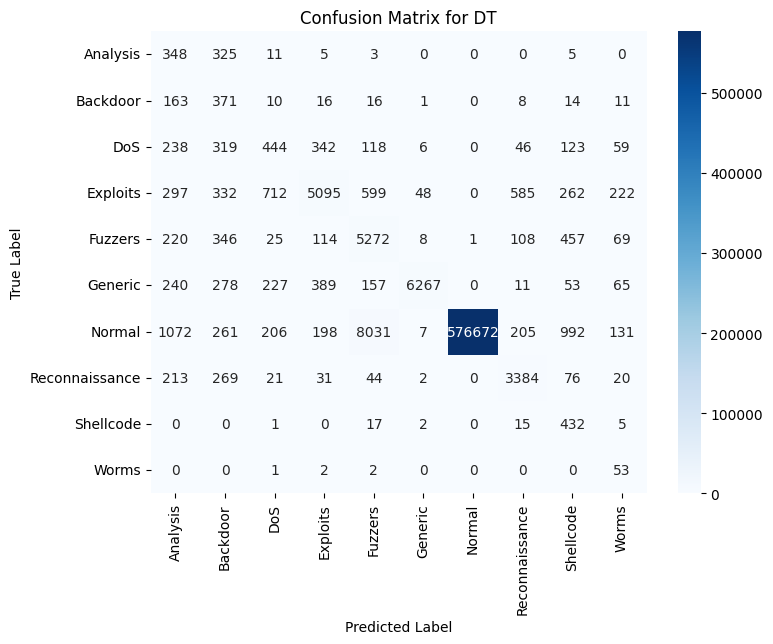

In [26]:
dt_acc =evaluate_result(y_test, dt_y_test_pred, 'DT')

## Random Forest

In [27]:

start_time = time.time() 

rf_y_test_pred=rf_clf.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 2.6959 seconds


Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.15      0.08       697
           1       0.04      0.13      0.06       610
           2       0.41      0.29      0.34      1695
           3       0.80      0.86      0.83      8152
           4       0.46      0.88      0.60      6620
           5       0.98      0.90      0.94      7687
           6       1.00      0.99      0.99    587775
           7       0.88      0.78      0.83      4060
           8       0.65      0.73      0.69       472
           9       0.67      0.62      0.64        58

    accuracy                           0.98    617826
   macro avg       0.59      0.63      0.60    617826
weighted avg       0.99      0.98      0.98    617826

+--------------------+--------------------+--------------------+-----------------+
|      Accuracy      |     Precision      |       Recall       |        F1       |
+--------------------+--------------------+---------

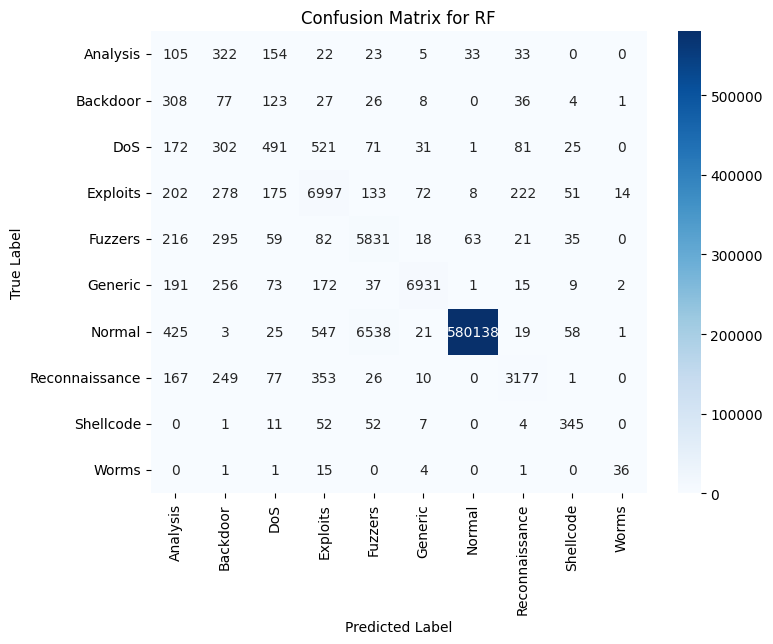

In [28]:

lr_acc =evaluate_result(y_test, rf_y_test_pred, 'RF')

## XGBoost

In [29]:

start_time = time.time() 

xgb_y_test_pred=xgb_clf.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 2.0029 seconds


Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.42      0.19       697
           1       0.16      0.68      0.25       610
           2       0.33      0.35      0.34      1695
           3       0.84      0.69      0.76      8152
           4       0.44      0.86      0.58      6620
           5       0.98      0.85      0.91      7687
           6       1.00      0.99      0.99    587775
           7       0.85      0.84      0.85      4060
           8       0.33      0.97      0.49       472
           9       0.33      0.93      0.49        58

    accuracy                           0.97    617826
   macro avg       0.54      0.76      0.58    617826
weighted avg       0.99      0.97      0.98    617826

+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+---

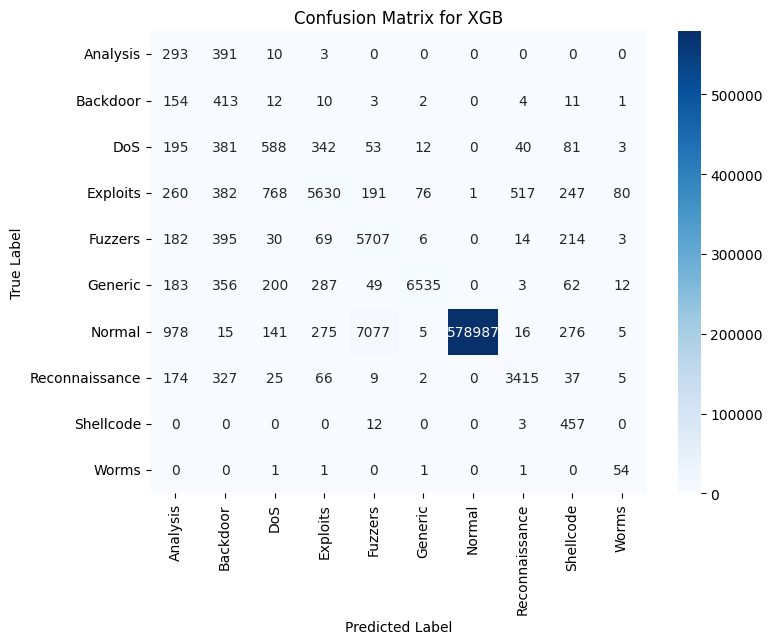

In [30]:

xgb_acc =evaluate_result(y_test, xgb_y_test_pred, 'XGB')

## Ensemble

In [31]:
start_time = time.time() 

v_clf_y_test_pred=v_clf.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 5.2291 seconds


Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.33      0.14       697
           1       0.06      0.21      0.09       610
           2       0.38      0.31      0.34      1695
           3       0.84      0.79      0.81      8152
           4       0.43      0.87      0.58      6620
           5       0.99      0.87      0.93      7687
           6       1.00      0.99      0.99    587775
           7       0.88      0.81      0.84      4060
           8       0.37      0.94      0.53       472
           9       0.28      0.88      0.43        58

    accuracy                           0.98    617826
   macro avg       0.53      0.70      0.57    617826
weighted avg       0.99      0.98      0.98    617826

+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+---

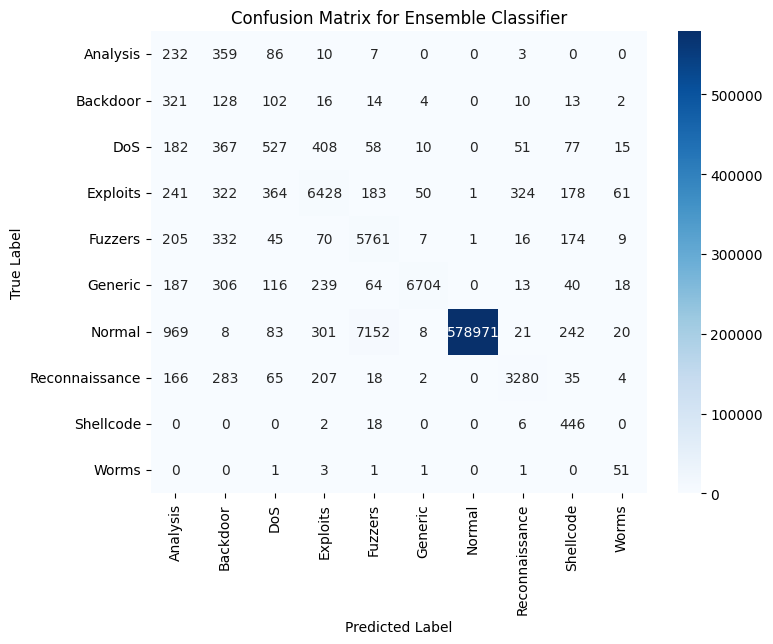

In [32]:

v_clf_acc =evaluate_result(y_test, v_clf_y_test_pred, 'Ensemble Classifier')